In [152]:
import codecs
import sklearn
import glob
import os
import time
import re
from datetime import datetime
import multiprocessing as mp
from multiprocessing import Pool
import pickle
import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sp
from scipy import stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [153]:
def load_workspace(filename):
 with open(filename, 'rb') as f:
  data_loaded = pickle.load(f)
 return data_loaded


In [154]:
data = load_workspace('data/pklForTheo.pkl')

In [ ]:

def genModelPreds_biasOC_d(outcomes,lr,d,p0):
    outcomes=np.array(outcomes)

    ocsDf = np.zeros(outcomes.shape)
    ocsDf[outcomes==-1]=-d
    ocsDf[outcomes==1]=1-d
        
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lr * (ocsDf[:,ii] - pred[:,ii])
    return pred 

def calcActProbsPosNegOC(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds=np.array(modelPreds)
    EVs=[preds*i for i in chVals]
    expEVs_sftmax=[np.exp(np.float64(i)/sftmax) for i in EVs]
    sftmax_denom=np.zeros(expEVs_sftmax[0].shape)
    for i in expEVs_sftmax:
        sftmax_denom+=i
    cols=['ch_{:02d}'.format(i) for i in np.arange(modelPreds.shape[1])+1]
    actProbArr=[pd.DataFrame(i/sftmax_denom, columns=cols) for i in expEVs_sftmax]
    return actProbArr

def genChoices(actProbArr):
    probCh=[np.zeros(actProbArr[0].shape)]
    choices=np.random.random_sample(actProbArr[0].shape)
    for i in range(len(actProbArr)):
        probCh.append(probCh[-1]+actProbArr[i])
        choices[choices<probCh[-1]]=i+1
    
    return choices#, probCh


def calcNegLogLike(choices, actProbs):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    for i in np.arange(len(actProbs)):
        chProbs[choices==i+1]=actProbs[i][choices==i+1]
    
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll, chProbs

def chanceLikelihood(choices, chanceP=0.2):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    
    chProbs[chProbs!=0]=chanceP
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll


#single LR sofented with sigmoid and biasedOC with sigmoid and p0 with no sigmoid, + fixed SM model
def optimizeLR_sft_fixedSM_posNegOC_p0(params, choices, outcomes, smax=1):
    lrp,d, p0=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    d=np.exp(d)/(np.exp(d)+1) #if softening d
    p0=(np.exp(p0)/(np.exp(p0)+1))*2-1 #if softening d
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_d(outcomes,lr,d,p0)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    return np.sum(nLL)


In [156]:
from operator import mod

def LRp0Dsim_choices_from_params(outcomes, lr, d, p0, smax, chVals=None):
    if chVals is None:
        chVals = np.arange(5) + 1
    preds =genModelPreds_biasOC_d(outcomes,lr,d,p0)
    actProbs =calcActProbsPosNegOC(preds, smax) # list of 5 DataFrames
    choices = genChoices(actProbs)
    return choices, preds, actProbs

In [157]:
datForAndrea = pd.read_csv('data/datForAndreaMerged.csv', index_col=0)

## Now the lottery data
rwlrnEstArr=data['rwlrnEstArr']
good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
rwlrnEstArr = rwlrnEstArr[rwlrnEstArr['PID'].isin(good_candidates)]
rwlrnOCArr=data['rwlrnOCArr']
rwlrnOCArr = rwlrnOCArr[rwlrnOCArr['PID'].isin(good_candidates)]
rwlrnSumm=data['rwlrnSumm']
rwlrnSumm = rwlrnSumm.rename(columns={'PROLIFIC_PID': 'PID'})
rwlrnSumm = rwlrnSumm[rwlrnSumm['PID'].isin(good_candidates)]
# do data wrangling to add the pre post switch parts to the outcome arrays
rwlrnOCArr = rwlrnOCArr.reset_index()
rwlrnOCArr = rwlrnOCArr.rename(columns={'index': 'ltround'})
rwlrnOCArr['ltround'] = rwlrnOCArr['ltround']+1




KeyError: 'PID'

In [ ]:
params_df = pd.read_csv(r"C:\Users\mnand\Desktop\SNE Data Analysis\notebooks\data\1LRp0D_LOT.csv")
params_df = params_df[['PROLIFIC_PID', 'subjLR_3prm', 'subjD_3prm', 'subjp0_3prm']]
params_df = params_df.rename(columns={
    'subjLR_3prm': 'lr',
    'subjD_3prm': 'd',
    'subjp0_3prm': 'p0'
})
params_df['smax'] = 1
params_df = params_df.rename(columns={'PROLIFIC_PID': 'PID'})
params = params_df.copy()

In [ ]:
#LETS TRY THIS
results = []

for PID in rwlrnOCArr.PID.unique():
    # ---- params ----
    param_row = params.loc[params['PID'] == PID].iloc[0]
    lr   = param_row.get('lr',   param_row.get('lr_pos', 0.5))
    d    = param_row.get('d',    0.0)
    p0   = param_row.get('p0',   0.0)
    smax = param_row.get('smax', 1.0)

    # ---- enforce trial order ----
    pid_df = (rwlrnOCArr.loc[rwlrnOCArr.PID == PID]
                        .sort_values('ltround')
                        .reset_index(drop=True))

    agent_cols = [c for c in pid_df.columns if c not in ['PID', 'ltround']]

    # trials x agents  ->  agents x trials (for the sim function)
    outcomes_for_sim = (pid_df[agent_cols]
                        .astype(float)          # preserve NaNs
                        * 2 - 1).T              # agents x trials

  
    outcomes_for_sim = outcomes_for_sim.dropna(how='all')

    if outcomes_for_sim.shape[0] == 0:
        continue

    # ---- simulate all agents in one call ----
    choices, preds, act_probs = LRp0Dsim_choices_from_params(
        outcomes_for_sim, lr, d, p0, smax=smax
    )
    # choices is agents x trials; convert to trials x agents for desired output
    choices_out = pd.DataFrame(choices, index=outcomes_for_sim.index).T  # trials x agents

    # ---- build output rows: one row per trial, agent columns ----
    out_df = choices_out.copy()
    out_df.insert(0, 'ltround', pid_df['ltround'].values[:out_df.shape[0]])
    out_df.insert(0, 'PID', PID)
    out_df['lr'] = lr
    out_df['d'] = d
    out_df['p0'] = p0
    out_df['smax'] = smax

    results.append(out_df)

sim_results_df = (pd.concat(results, ignore_index=True)
                    .sort_values(['PID', 'ltround'])
                    .reset_index(drop=True))

sim_results_df.index = rwlrnEstArr.index
sim_results_df.to_csv('simulated_choices.csv', index=True)

In [ ]:
def clean_data(sim_results_df):
    # Sort by column: 'p0' (ascending)
    
    # Drop columns: 'smax', 'lr' and 2 other columns
    sim_results_df = sim_results_df.drop(columns=['smax', 'lr', 'd', 'p0','ltround'])
    return sim_results_df

sim_results_df = clean_data(sim_results_df.copy())
sim_results_df.head()

,PID,"0.2,0.65","0.35,0.65","0.35,0.8","0.65,0.2","0.8,0.2","0.8,0.35","0.2,0.8","0.65,0.35"
3,633471b7c7b5fa52a0a407a7,1,2.0,1,5,NaN,4,1.0,NaN
4,633471b7c7b5fa52a0a407a7,3,4.0,1,4,NaN,5,1.0,NaN
21,633471b7c7b5fa52a0a407a7,5,3.0,2,3,NaN,3,1.0,NaN
2,633471b7c7b5fa52a0a407a7,5,5.0,3,4,NaN,5,5.0,NaN
20,633471b7c7b5fa52a0a407a7,4,5.0,5,1,NaN,3,5.0,NaN


In [ ]:

def clean_data(rwlrnSumm):
    # Sort by column: 'subjD_3prm' (ascending)
    rwlrnSumm = rwlrnSumm.sort_values(['subjD_3prm'])
    # Drop columns: 'subjLR_3prm', 'subjD_3prm' and 3 other columns
    rwlrnSumm = rwlrnSumm.drop(columns=['subjLR_3prm', 'subjD_3prm', 'subjp0_3prm', 'subjNLL_3prm', 'subjLRTp_3prm'])
    return rwlrnSumm

rwlrnSumm= clean_data(rwlrnSumm.copy())

In [ ]:
PID = '63eeaedb26e599e86e8f7929'
for PID in rwlrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    # print('subj: {}'.format(PID))
    rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    T = rwestDat.shape[1]
    rwestDat.columns = [f'ch_{t+1:02d}' for t in range(T)]
    rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
    rwlrs_nll=np.inf

rwestDat

subj_371 (0:03:24.575088:0.2f): 55c694e3fdf99b6c4f28595f
subj_372 (0:03:24.588089:0.2f): 55d86f3569dbc30012b6869f
subj_373 (0:03:24.602098:0.2f): 55e7221441988f000b75cc7a
subj_374 (0:03:24.610096:0.2f): 560ce65601c38a0012769e20
subj_375 (0:03:24.624098:0.2f): 56b8de29e1d0a200051517f8
subj_376 (0:03:24.636098:0.2f): 570fa921f895a7000f38ca6f
subj_377 (0:03:24.647511:0.2f): 571144323d47e800096358d9
subj_378 (0:03:24.662627:0.2f): 572041d6fd3a5200093c1295
subj_379 (0:03:24.677639:0.2f): 5722c95274e7ff0011a6f011
subj_380 (0:03:24.689648:0.2f): 5766d2f7fdff7a0001c1285b
subj_381 (0:03:24.698639:0.2f): 5783d80d275be60001358349
subj_382 (0:03:24.708638:0.2f): 58016c9f551314000145af58
subj_383 (0:03:24.719646:0.2f): 580777dd827ca10001db494b
subj_384 (0:03:24.732638:0.2f): 582009dd87f6b90001f13e40
subj_385 (0:03:24.744652:0.2f): 594936ad4152bf0001bfd5cd
subj_386 (0:03:24.751149:0.2f): 5971640e7ec240000170cb69
subj_387 (0:03:24.760149:0.2f): 59aae1188cef7d00011f8884
subj_388 (0:03:24.767150:0.2f):

,ch_01,ch_02,ch_03,ch_04,ch_05,ch_06,ch_07,ch_08,ch_09,ch_10,...,ch_13,ch_14,ch_15,ch_16,ch_17,ch_18,ch_19,ch_20,ch_21,ch_22
ltround,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
"0.2,0.65",2,4,3,4,1,5,5,5,5,5,...,5,5,1,4,2,1,5,2,4,2
"0.35,0.8",5,5,5,4,5,5,5,3,5,1,...,2,5,3,3,5,5,3,4,4,4
"0.65,0.2",5,4,4,4,5,5,3,5,4,5,...,5,3,4,1,5,1,4,1,5,5
"0.8,0.2",5,5,5,5,2,5,5,5,5,3,...,4,5,4,5,1,4,4,5,5,5
"0.8,0.35",2,5,5,5,4,4,4,4,4,5,...,5,4,2,5,4,5,5,5,5,3
lr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
p0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
smax,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
#FIT THE LOTTERY DATA WITH A BIASED OUTCOME (d) single LR MODEL and initialEstimate
import codecs
import glob
import os
import time
import re
from datetime import datetime

start_time = datetime.now()
smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
subj_ids = data['subjs']  # Replace with the actual key or source for subject IDs

rwlrnEstArr=sim_results_df


# Add PID column to each DataFrame if missing
for key in ['rwlrnEstArr', 'rwlrnOCArr', 'rwlrnSumm']:
    df = data[key]
    if 'PID' not in df.columns:
        df['PID'] = subj_ids
    data[key] = df


print('FITTING...')
fitCount=0;
for PID in rwlrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    # print('subj: {}'.format(PID))
    rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    T = rwestDat.shape[1]
    rwestDat.columns = [f'ch_{t+1:02d}' for t in range(T)]
    rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
    rwlrs_nll=np.inf
    for lrs, ds, p0s in zip(lrRange,dRange, p0Range):
            result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC_p0, (lrs,ds,p0s),(rwestDat, rwocDat),bounds=((-10,10),(-10,10),(-1,1)))
            if result_s.fun < rwlrs_nll:
                rwlrs_nll = result_s.fun
                rwlrs_lr = result_s.x[0]
                rwlrs_d = result_s.x[1]
                rwlrs_p0 = result_s.x[2]
 
    rwlrnSumm.loc[PID,'subjLR_3prm']=np.exp(rwlrs_lr)/(np.exp(rwlrs_lr)+1)
    rwlrnSumm.loc[PID,'subjD_3prm']=np.exp(rwlrs_d)/(np.exp(rwlrs_d)+1)
    rwlrnSumm.loc[PID,'subjp0_3prm']=rwlrs_p0
    rwlrnSumm.loc[PID,'subjNLL_3prm']=rwlrs_nll
    rwchncNLL=np.sum(chanceLikelihood(rwestDat))
    rwlrnSumm.loc[PID, 'subjLRTp_3prm']=stats.chi2.sf(2*(rwchncNLL-rwlrnSumm.loc[PID,'subjNLL_3prm']),1)

    # print(rwlrnSumm.loc[PID,'subjLR_3prm'])
    # print(rwlrnSumm.loc[PID,'subjD_3prm'])
    # print(rwlrnSumm.loc[PID,'subjp0_3prm'])    
    
rwlrnSumm=rwlrnSumm.loc[:,rwlrnSumm.columns[~rwlrnSumm.columns.str.startswith('qa:')].append(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')
rwlrnSumm.to_csv('BiasOut1LR_LOT.csv')
rwlrnSumm

FITTING...
subj_001 (0:00:00.003017:0.2f): 55c694e3fdf99b6c4f28595f
subj_002 (0:00:08.348456:0.2f): 55d86f3569dbc30012b6869f
subj_003 (0:00:18.767090:0.2f): 55e7221441988f000b75cc7a
subj_004 (0:00:31.865035:0.2f): 560ce65601c38a0012769e20


KeyboardInterrupt: 

In [ ]:
sims = sim_results_df.copy()
import pandas as pd

# Read in the PrePost_TRUST.csv file and rename PROLIFIC_PID to PID
prepost_df = pd.read_csv(r"C:\Users\mnand\Desktop\SNE Data Analysis\notebooks\PrePost_TRUST.csv")
if 'PROLIFIC_PID' in prepost_df.columns:
    prepost_df = prepost_df.rename(columns={'PROLIFIC_PID': 'PID'})

# Rename parameter columns in prepost_df to match sims
prepost_df = prepost_df.rename(columns={
    'subjLR_3prm': 'lr',
    'subjp0_3prm': 'p0',
    'subjD_3prm': 'd'
})

# Ensure PID is present and unique in both DataFrames
if 'PID' not in sims.columns:
    raise ValueError("sims DataFrame must have a 'PID' column.")
if 'PID' not in prepost_df.columns:
    raise ValueError("PrePost_TRUST.csv must have a 'PID' column.")

# Merge on PID (inner join to keep only matching PIDs)
merged = pd.merge(sims, prepost_df, on='PID', suffixes=('_sim', '_recovered'))

# List parameter columns to compare
param_cols = ['lr', 'p0', 'd']

# Calculate and print correlations for each parameter
for col in param_cols:
    sim_col = f"{col}_sim"
    prepost_col = f"{col}_recovered"
    if sim_col in merged.columns and prepost_col in merged.columns:
        corr = merged[sim_col].corr(merged[prepost_col])
        print(f"Correlation for {col}: {corr:.3f}")

# Optionally, show a summary DataFrame
merged[[f"{col}_sim" for col in param_cols if f"{col}_sim" in merged.columns] +
       [f"{col}_recovered" for col in param_cols if f"{col}_recovered" in merged.columns]].head()
sims
prepost_df

Correlation for lr: -0.086
Correlation for p0: 0.877
Correlation for d: 0.451


,PID,ltround,"0.2,0.65","0.35,0.65","0.35,0.8","0.65,0.2","0.8,0.2","0.8,0.35",lr,d,p0,smax,"0.2,0.8","0.65,0.35"
0,55c694e3fdf99b6c4f28595f,1,5.0,4.0,5.0,3.0,NaN,5.0,0.180488,0.000045,1.0000,1,5.0,NaN
1,55c694e3fdf99b6c4f28595f,2,5.0,5.0,5.0,5.0,NaN,5.0,0.180488,0.000045,1.0000,1,5.0,NaN
2,55c694e3fdf99b6c4f28595f,3,5.0,5.0,2.0,5.0,NaN,5.0,0.180488,0.000045,1.0000,1,5.0,NaN
3,55c694e3fdf99b6c4f28595f,4,5.0,4.0,3.0,5.0,NaN,4.0,0.180488,0.000045,1.0000,1,3.0,NaN
4,55c694e3fdf99b6c4f28595f,5,5.0,3.0,4.0,5.0,NaN,5.0,0.180488,0.000045,1.0000,1,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8003,641ec1a9d9fe8a0941e39862,18,3.0,NaN,5.0,5.0,2.0,5.0,0.100849,0.000045,0.8572,1,NaN,5.0
8004,641ec1a9d9fe8a0941e39862,19,3.0,NaN,3.0,2.0,3.0,5.0,0.100849,0.000045,0.8572,1,NaN,5.0
8005,641ec1a9d9fe8a0941e39862,20,5.0,NaN,2.0,4.0,5.0,4.0,0.100849,0.000045,0.8572,1,NaN,5.0
8006,641ec1a9d9fe8a0941e39862,21,5.0,NaN,4.0,5.0,2.0,5.0,0.100849,0.000045,0.8572,1,NaN,5.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


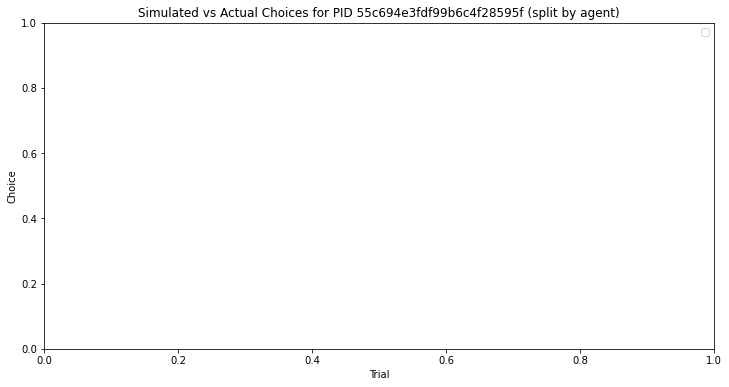

In [ ]:
import matplotlib.pyplot as plt

# Example: plot for one PID, all agents
pid = rwlrnEstArr.PID.unique()[0]
sim_row = sim_results_df[sim_results_df.PID == pid]
actual_row = rwlrnEstArr[rwlrnEstArr.PID == pid]

agent_cols = [col for col in sim_row.columns if col.startswith('ch_')]

plt.figure(figsize=(12, 6))
for agent in agent_cols:
    plt.plot(sim_row[agent].values, label=f'Simulated {agent}', linestyle='--')
    plt.plot(actual_row[agent].values, label=f'Actual {agent}', alpha=0.7)
plt.xlabel('Trial')
plt.ylabel('Choice')
plt.title(f'Simulated vs Actual Choices for PID {pid} (split by agent)')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Apply transformation
params_df['p0_trans'] = (np.exp(params_df['p0']) / (np.exp(params_df['p0']) + 1)) * 2 - 1

# Plot before and after
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(params_df['p0'], bins=30, alpha=0.7)
plt.title('Original p0')
plt.subplot(1,2,2)
plt.hist(params_df['p0_trans'], bins=30, alpha=0.7, color='orange')
plt.title('Transformed p0 (sigmoid*2-1)')
plt.tight_layout()
plt.show()